In [1]:
!pip install gdown
!pip install pandas
!pip install opencv-python
!pip install matplotlib
!pip install imgaug
!pip install scikit-learn
!pip install prettytable
!pip install numba
!pip install seaborn

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/cb/56/f4845ed78723a4eb8eb22bcfcb46e1157a462c78c0a5ed318c68c98f9a79/gdown-5.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/6e/b5/15b3b36f298bcbc0be82a371ac744f4f5a10309ade0b8bbde286598dd612/filelock-3.13.4-py3-none-any.whl.metadata
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/2a/14/e75e52d521442e2fcc9f1df3c5e456aead034203d4797867980de558ab34/tqdm-4.66.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for PySocks!=1.5.7,>=1.5.6 from https://files.pythonhosted.org/packages/8d/59/b4572118e098ac8e46e399a1dd0f2d85403ce8bbaad9ec79373ed6badaf9/PySocks-1.7.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 26.7 MB/s eta 0:00:00

[notice] A new release of pip is av

In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imgaug import augmenters
import matplotlib.gridspec as gridspec
from PIL import Image
import os
import json
import glob
import time
import datetime
from collections import Counter
from concurrent import futures
import threading
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from prettytable import PrettyTable
import zipfile
import seaborn as sns
import gdown
from numba import cuda

2024-04-17 18:13:20.790443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 18:13:20.790521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 18:13:20.790566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 18:13:20.800142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Using all Cropped Types

In [3]:
with zipfile.ZipFile("/workspace/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/workspace/train")

In [2]:
base_dir = os.path.join('/workspace/train/dataset/train')
type1_dir = os.path.join(base_dir,'Type_1_Cropped')
type2_dir = os.path.join(base_dir,'Type_2_Cropped')
type3_dir = os.path.join(base_dir,'Type_3_Uncropped')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

len(type1_files),len(type2_files),len(type3_files)

(682, 4063, 2226)

In [3]:
#Building a dataframe mapping images and Cancer type
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/workspace/train/dataset/train/Type_1_Cropped/...,Type_1
1,/workspace/train/dataset/train/Type_2_Cropped/...,Type_2
2,/workspace/train/dataset/train/Type_2_Cropped/...,Type_2
3,/workspace/train/dataset/train/Type_2_Cropped/...,Type_2
4,/workspace/train/dataset/train/Type_2_Cropped/...,Type_2


## Data Augmentation

In [4]:
# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.20),
    tf.keras.layers.RandomZoom(0.10),
])


2024-04-17 18:13:38.098941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46872 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:a5:00.0, compute capability: 8.6


## Preprocessing

In [5]:
data_array = []
data_labels = []
IMG_DIMS = (224, 224)

for i in tqdm(range(len(files_df))):
    img_path = files_df['filename'][i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=IMG_DIMS,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    data_array.append(img)
    data_labels.append(files_df['label'][i])


100%|██████████| 6971/6971 [00:07<00:00, 951.82it/s]


In [6]:
data_array = np.array(data_array)
data_labels = np.array(data_labels)

In [7]:
idx_Type_1 = np.where(data_labels=="Type_1")[0]
idx_Type_2 = np.where(data_labels=="Type_2")[0]
idx_Type_3 = np.where(data_labels=="Type_3")[0]

In [8]:
augmented_images_type1 = data_augmentation(data_array[idx_Type_1])
augmented_images_type3 = data_augmentation(data_array[idx_Type_3])

2024-04-17 18:13:48.417035: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [9]:
# type_1_idx = np.where(np.array(data_labels) == "Type_1")[0]
# type1_aug = data_array[type_1_idx]
# augmented_images = data_augmentation(type1_aug)

In [10]:
data_array = np.concatenate((data_array,augmented_images_type1))

In [11]:
data_array.shape

(7653, 224, 224, 3)

In [12]:
data_labels = np.concatenate((data_labels,np.array(["Type_1"]*len(augmented_images_type1))))

In [13]:
len(data_labels)

7653

In [14]:
data_array = np.concatenate((data_array,augmented_images_type3))

In [15]:
data_labels = np.concatenate((data_labels,np.array(["Type_3"]*len(augmented_images_type3))))

In [16]:
data_array.shape

(9879, 224, 224, 3)

In [17]:
len(data_labels)

9879

In [18]:
# data_labels = np.concatenate((data_labels,data_labels))

# Train-Val Split

In [19]:
#split training,dev and test set : 80:10:10

train_files, val_files, train_labels, val_labels = train_test_split(data_array,
                                                                      data_labels,
                                                                      test_size=0.10, random_state=42)

print(train_files.shape, val_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels))

(8891, 224, 224, 3) (988, 224, 224, 3)
Train: Counter({'Type_3': 4015, 'Type_2': 3636, 'Type_1': 1240}) 
Val: Counter({'Type_3': 437, 'Type_2': 427, 'Type_1': 124})


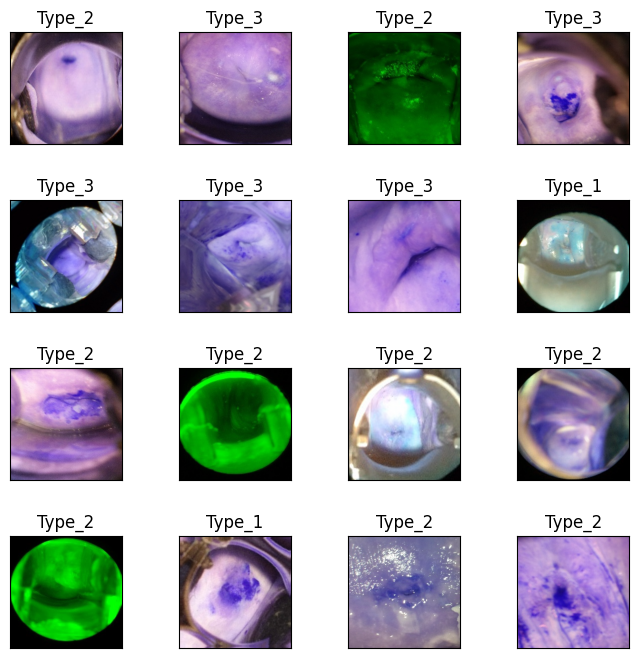

In [20]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , train_files.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_files[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [21]:
#encode text categories with labels
BATCH_SIZE = 64
NUM_CLASSES = 3
EPOCHS = 50
INPUT_SHAPE = (224, 224, 3)

train_imgs_scaled = train_files  / 255.
val_imgs_scaled = val_files  / 255.

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = to_categorical(train_labels_enc, num_classes=3)
val_labels_1hotenc = to_categorical(val_labels_enc, num_classes=3)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

['Type_1' 'Type_2' 'Type_3' 'Type_2' 'Type_1' 'Type_3'] [0 1 2 1 0 2]
['Type_1' 'Type_2' 'Type_3' 'Type_2' 'Type_1' 'Type_3'] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [44]:
test_base_dir = os.path.join('/workspace/train/dataset/test')
type1_test_dir = os.path.join(test_base_dir,'Type_1')
type2_test_dir = os.path.join(test_base_dir,'Type_2')
type3_test_dir = os.path.join(test_base_dir,'Type_3')

type1_test_files = glob.glob(type1_test_dir+'/*.jpg')
type2_test_files = glob.glob(type2_test_dir+'/*.jpg')
type3_test_files = glob.glob(type3_test_dir+'/*.jpg')

len(type1_test_files),len(type2_test_files),len(type3_test_files)

(200, 200, 200)

In [45]:
#Building a dataframe mapping images and Cancer type
np.random.seed(42)

test_files_df = pd.DataFrame({
    'filename': type1_test_files + type2_test_files + type3_test_files,
    'label': ['Type_1'] * len(type1_test_files) + ['Type_2'] * len(type2_test_files) + ['Type_3'] * len(type3_test_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)


In [46]:
test_files_df.label.value_counts()

label
Type_1    200
Type_3    200
Type_2    200
Name: count, dtype: int64

In [47]:
test_array = []
test_labels = []
IMG_DIMS = (224, 224)

for i in tqdm(range(len(test_files_df))):
    img_path = test_files_df['filename'][i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=IMG_DIMS,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    test_array.append(img)
    test_labels.append(test_files_df['label'][i])


100%|██████████| 600/600 [00:00<00:00, 1152.62it/s]


In [48]:
#scaling the test set and one-hot encoding the test labels
test_labels= np.array(test_labels)
test_imgs_scaled = np.array(test_array) / 255.
test_imgs_scaled.shape, test_labels.shape

le = LabelEncoder()
le.fit(test_labels)
test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = to_categorical(test_labels_enc, num_classes=3)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_1' 'Type_3' 'Type_3' 'Type_1' 'Type_1' 'Type_2'] [0 2 2 0 0 1]
['Type_1' 'Type_3' 'Type_3' 'Type_1' 'Type_1' 'Type_2'] [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


# Training

## NASNET

In [ ]:
# Load NASNetLarge model without the top (classification) layers
nasnetNet = tf.keras.applications.NASNetLarge(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
nasnetNet.trainable = False

# Freeze the layers
for layer in nasnetNet.layers:
    layer.trainable = False

# Define additional layers for classification
base_nasnet = nasnetNet.output
pool_out_nasnet = tf.keras.layers.GlobalAveragePooling2D()(base_nasnet)
hidden1_nasnet = tf.keras.layers.Dense(512, activation='relu')(pool_out_nasnet)
batch_norm1_nasnet = tf.keras.layers.BatchNormalization()(hidden1_nasnet)
drop1_nasnet = tf.keras.layers.Dropout(rate=0.3)(batch_norm1_nasnet)
hidden2_nasnet = tf.keras.layers.Dense(512, activation='relu')(drop1_nasnet)
batch_norm2_nasnet = tf.keras.layers.BatchNormalization()(hidden2_nasnet)
drop2_nasnet = tf.keras.layers.Dropout(rate=0.3)(batch_norm2_nasnet)
out_nasnet = tf.keras.layers.Dense(3, activation='softmax')(drop2_nasnet)

# Define the model
nasnet_model = tf.keras.Model(inputs=nasnetNet.input, outputs=out_nasnet)

# Compile the model
nasnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print model summary
nasnet_model.summary()

In [31]:
EPOCHS = 50
nasnet_history = nasnet_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                validation_data=(val_imgs_scaled, val_labels_1hotenc),
                                verbose=1)

Epoch 1/50


2024-04-17 17:37:20.900274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-17 17:37:22.179413: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 17:37:24.145969: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd788f0aeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 17:37:24.146021: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-17 17:37:24.155631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 17:37:24.271915: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 [==============================] - 56s 286ms/step - loss: 1.3241 - accuracy: 0.4692 - val_loss: 0.9583 - val_accuracy: 0.5683
Epoch 2/50
137/137 [==============================] - 36s 260ms/step - loss: 1.0248 - accuracy: 0.5735 - val_loss: 0.8391 - val_accuracy: 0.6228
Epoch 3/50
137/137 [==============================] - 34s 247ms/step - loss: 0.8837 - accuracy: 0.6293 - val_loss: 0.7753 - val_accuracy: 0.6547
Epoch 4/50
137/137 [==============================] - 34s 248ms/step - loss: 0.7807 - accuracy: 0.6660 - val_loss: 0.7863 - val_accuracy: 0.6547
Epoch 5/50
137/137 [==============================] - 34s 250ms/step - loss: 0.7077 - accuracy: 0.6993 - val_loss: 0.7873 - val_accuracy: 0.6403
Epoch 6/50
137/137 [==============================] - 34s 246ms/step - loss: 0.6320 - accuracy: 0.7357 - val_loss: 0.7803 - val_accuracy: 0.6588
Epoch 7/50
137/137 [==============================] - 34s 245ms/step - loss: 0.5702 - accuracy: 0.7641 - val_loss: 0.7873 - val_accuracy: 0.6

19/19 [==============================] - 2s 117ms/step - loss: 1.9375 - accuracy: 0.6400
+---------------------+--------+
|        NASNet       |        |
+---------------------+--------+
| Model Accuracy in % | 98.44  |
|  Test Accuracy in % | 64.00  |
|    Test Loss in %   | 193.75 |
+---------------------+--------+


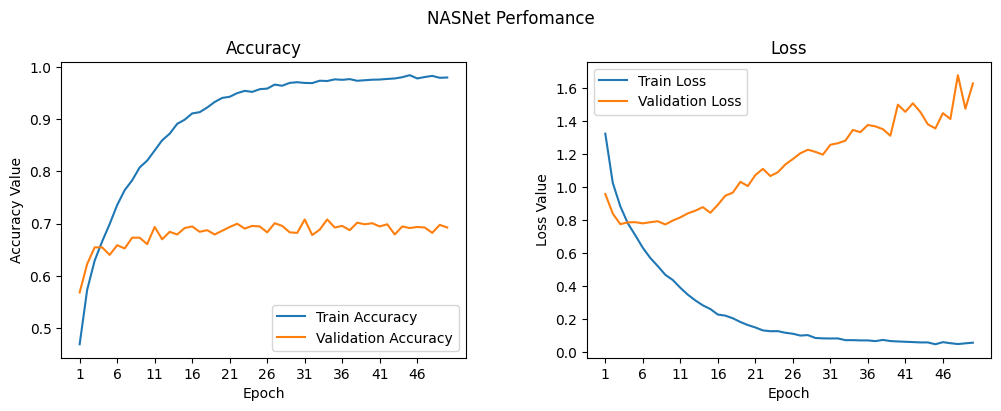

In [32]:
# NASNet Model Evaluation
nasnet_model_accuracy = nasnet_history.history['accuracy'][np.argmin(nasnet_history.history['loss'])]
nasnet_model_score = nasnet_model.evaluate(test_imgs_scaled, test_labels_1hotenc)
nasnet_Summary = PrettyTable(["NASNet", " "])
nasnet_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(nasnet_model_accuracy*100)])
nasnet_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(nasnet_model_score[1]*100)])
nasnet_Summary.add_row(["Test Loss in %", "{:.2f}".format(nasnet_model_score[0]*100)])
print(nasnet_Summary)

# Plotting performance for NASNet
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('NASNet Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch_nasnet = len(nasnet_history.history['accuracy']) + 1
epoch_list_nasnet = list(range(1, max_epoch_nasnet))
ax1.plot(epoch_list_nasnet, nasnet_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list_nasnet, nasnet_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch_nasnet, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1_nasnet = ax1.legend(loc="best")

ax2.plot(epoch_list_nasnet, nasnet_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list_nasnet, nasnet_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch_nasnet, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2_nasnet = ax2.legend(loc="best")


19/19 [==============================] - 6s 108ms/step


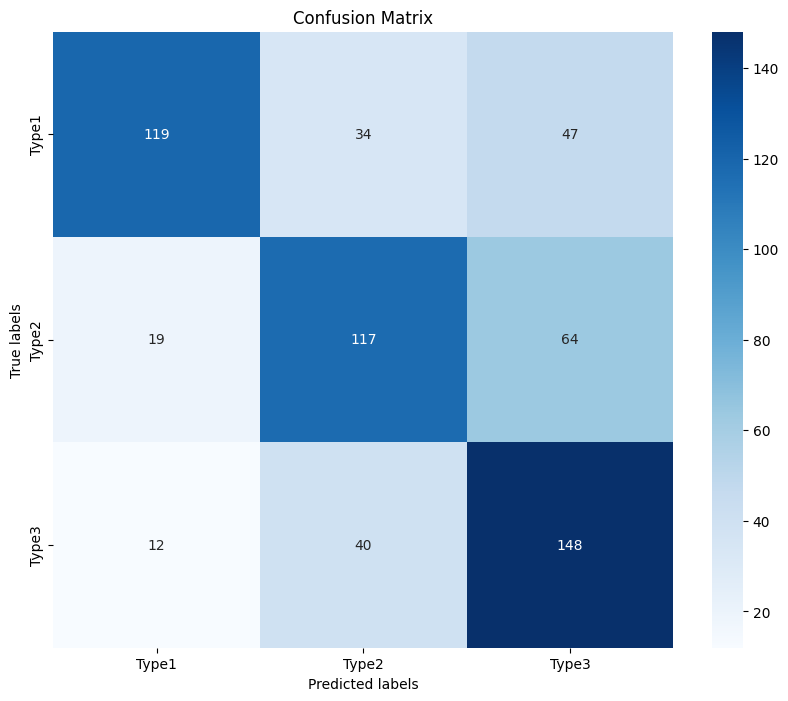

In [33]:
# Assuming 'predictions' contains the predicted labels and 'true_labels' contains the true labels
predictions = nasnet_model.predict(test_imgs_scaled) # Example: Replace 'model' and 'test_data' with your actual model and test data
predicted_labels = np.argmax(predictions, axis=1)  # Assuming predictions are one-hot encoded, convert them back to labels
true_labels = np.argmax(test_labels_1hotenc, axis=1)  # Assuming 'test_labels' contains the true labels

# Compute confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
class_names = ['Type1', 'Type2', 'Type3'] 
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [35]:
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

       Type1       0.79      0.59      0.68       200
       Type2       0.61      0.58      0.60       200
       Type3       0.57      0.74      0.64       200

    accuracy                           0.64       600
   macro avg       0.66      0.64      0.64       600
weighted avg       0.66      0.64      0.64       600



## VGG16

In [40]:
vgg16Net = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',
                                            input_shape=INPUT_SHAPE)
vgg16Net.trainable = False
# Freeze the layers
for layer in vgg16Net.layers:
    layer.trainable = False

base_vgg16 = vgg16Net
base_out_vgg16 = base_vgg16.output
pool_out_vgg16 = tf.keras.layers.Flatten()(base_out_vgg16)
hidden1_vgg16 = tf.keras.layers.Dense(512, activation='relu')(pool_out_vgg16)
batch_norm1_vgg16 = tf.keras.layers.BatchNormalization()(hidden1_vgg16)
drop1_vgg16 = tf.keras.layers.Dropout(rate=0.3)(batch_norm1_vgg16)
hidden2_vgg16 = tf.keras.layers.Dense(512, activation='relu')(drop1_vgg16)
batch_norm2_vgg16 = tf.keras.layers.BatchNormalization()(hidden2_vgg16)
drop2_vgg16 = tf.keras.layers.Dropout(rate=0.3)(batch_norm2_vgg16)
out_vgg16 = tf.keras.layers.Dense(3, activation='softmax')(drop2_vgg16)

vgg16_model = tf.keras.Model(inputs=base_vgg16.input, outputs=out_vgg16)
vgg16_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
vgg16_model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [41]:
EPOCHS = 5

# Fit the model with callbacks
vgg16_history = vgg16_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                validation_data=(val_imgs_scaled, val_labels_1hotenc),
                                verbose=1)


Epoch 1/5


2024-04-16 19:24:21.088767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-16 19:24:21.225985: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 19:24:24.775020: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5ab1cf5bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 19:24:24.775049: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-04-16 19:24:24.781654: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-16 19:24:24.901442: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 [==============================] - 25s 126ms/step - loss: 1.2266 - accuracy: 0.5216 - val_loss: 0.8848 - val_accuracy: 0.5838
Epoch 2/5
137/137 [==============================] - 15s 110ms/step - loss: 0.8480 - accuracy: 0.6486 - val_loss: 0.9032 - val_accuracy: 0.6280
Epoch 3/5
137/137 [==============================] - 15s 106ms/step - loss: 0.6779 - accuracy: 0.7210 - val_loss: 0.8006 - val_accuracy: 0.6855
Epoch 4/5
137/137 [==============================] - 14s 105ms/step - loss: 0.5841 - accuracy: 0.7609 - val_loss: 0.8692 - val_accuracy: 0.6536
Epoch 5/5
137/137 [==============================] - 14s 102ms/step - loss: 0.5019 - accuracy: 0.7964 - val_loss: 0.9822 - val_accuracy: 0.6218


19/19 [==============================] - 1s 46ms/step - loss: 1.2544 - accuracy: 0.5350
+---------------------+--------+
|        VGG16        |        |
+---------------------+--------+
| Model Accuracy in % | 79.64  |
|  Test Accuracy in % | 53.50  |
|    Test Loss in %   | 125.44 |
+---------------------+--------+


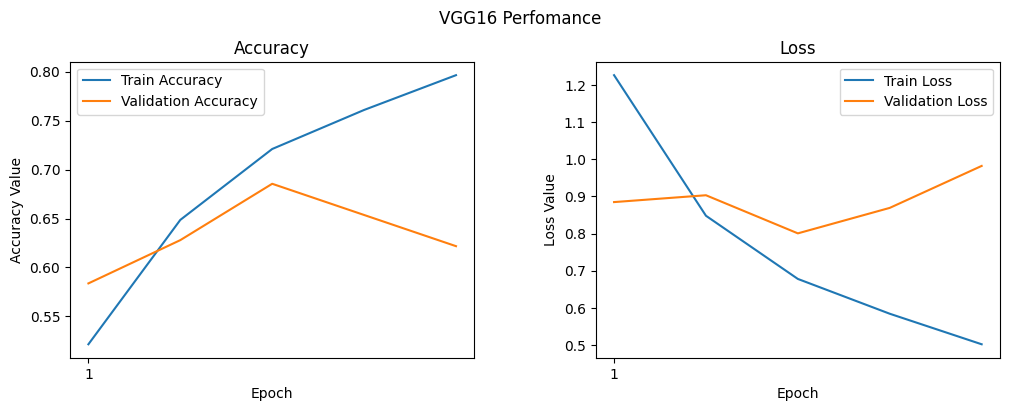

In [60]:
vgg16_model_accuracy = vgg16_history.history['accuracy'][np.argmin(vgg16_history.history['loss'])]
vgg16_model_score=vgg16_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
vgg16_Summary = PrettyTable(["VGG16"," "])
vgg16_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(vgg16_model_accuracy*100)])
vgg16_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(vgg16_model_score[1]*100)])
vgg16_Summary.add_row(["Test Loss in %", "{:.2f}".format(vgg16_model_score[0]*100)])

print(vgg16_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(vgg16_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, vgg16_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, vgg16_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, vgg16_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, vgg16_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [57]:
vgg16_model.predict(test_imgs_scaled)

19/19 [==============================] - 1s 42ms/step


array([[0.96952784, 0.02921848, 0.00125371],
       [0.23980631, 0.28208685, 0.4781069 ],
       [0.01191956, 0.9307627 , 0.0573178 ],
       ...,
       [0.08561585, 0.9040469 , 0.01033731],
       [0.11992053, 0.15882394, 0.72125554],
       [0.0109516 , 0.87578183, 0.11326653]], dtype=float32)

In [58]:
# Assuming 'predictions' contains the predicted labels and 'true_labels' contains the true labels
predictions = vgg16_model.predict(test_imgs_scaled) # Example: Replace 'model' and 'test_data' with your actual model and test data
predicted_labels = np.argmax(predictions, axis=1)  # Assuming predictions are one-hot encoded, convert them back to labels
true_labels = np.argmax(test_labels_1hotenc, axis=1)  # Assuming 'test_labels' contains the true labels

19/19 [==============================] - 1s 43ms/step


19/19 [==============================] - 1s 42ms/step


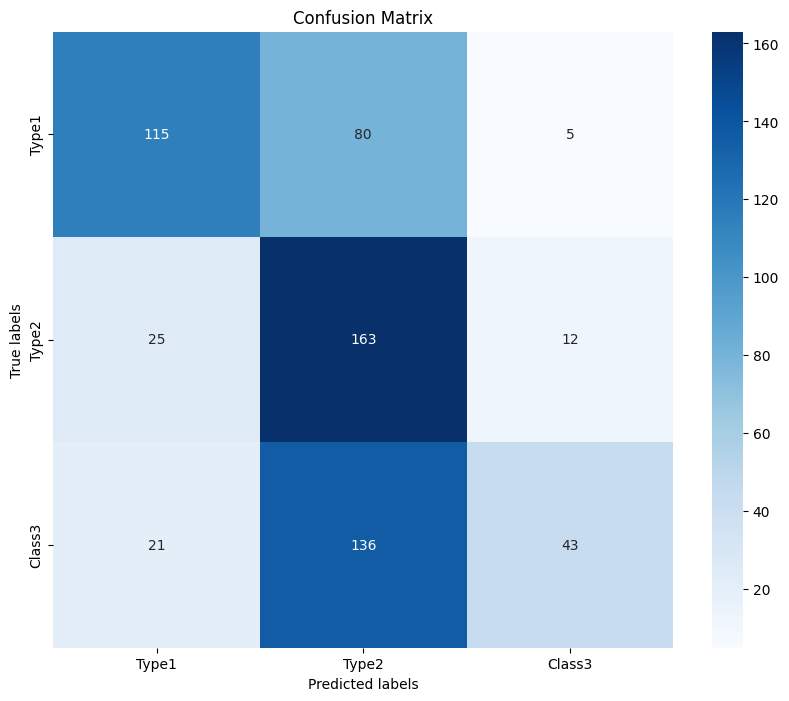

In [59]:
# Assuming 'predictions' contains the predicted labels and 'true_labels' contains the true labels
predictions = vgg16_model.predict(test_imgs_scaled) # Example: Replace 'model' and 'test_data' with your actual model and test data
predicted_labels = np.argmax(predictions, axis=1)  # Assuming predictions are one-hot encoded, convert them back to labels
true_labels = np.argmax(test_labels_1hotenc, axis=1)  # Assuming 'test_labels' contains the true labels

# Compute confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
class_names = ['Type1', 'Type2', 'Type3'] 
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# ResNet

In [ ]:
resnetNet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet',
                                           input_shape=INPUT_SHAPE)
resnetNet.trainable = False

# Freeze the layers
for layer in resnetNet.layers:
    layer.trainable = False

base_resnet = resnetNet
base_out_resnet = base_resnet.output
pool_out_resnet = tf.keras.layers.GlobalAveragePooling2D()(base_out_resnet)
hidden1_resnet = tf.keras.layers.Dense(512, activation='relu')(pool_out_resnet)
batch_norm1_resnet = tf.keras.layers.BatchNormalization()(hidden1_resnet)
drop1_resnet = tf.keras.layers.Dropout(rate=0.3)(batch_norm1_resnet)
hidden2_resnet = tf.keras.layers.Dense(512, activation='relu')(drop1_resnet)
batch_norm2_resnet = tf.keras.layers.BatchNormalization()(hidden2_resnet)
drop2_resnet = tf.keras.layers.Dropout(rate=0.3)(batch_norm2_resnet)
out_resnet = tf.keras.layers.Dense(3, activation='softmax')(drop2_resnet)

resnet_model = tf.keras.Model(inputs=base_resnet.input, outputs=out_resnet)
resnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

resnet_model.summary()

In [32]:
# Training
EPOCHS = 5
resnet_history = resnet_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  validation_data=(val_imgs_scaled, val_labels_1hotenc),
                                  verbose=1)



Epoch 1/5
137/137 [==============================] - 16s 112ms/step - loss: 1.3313 - accuracy: 0.4173 - val_loss: 1.0400 - val_accuracy: 0.4419
Epoch 2/5
137/137 [==============================] - 13s 93ms/step - loss: 1.2124 - accuracy: 0.4601 - val_loss: 1.0000 - val_accuracy: 0.4573
Epoch 3/5
137/137 [==============================] - 10s 74ms/step - loss: 1.1347 - accuracy: 0.4906 - val_loss: 0.9873 - val_accuracy: 0.4697
Epoch 4/5
137/137 [==============================] - 11s 81ms/step - loss: 1.0736 - accuracy: 0.5212 - val_loss: 1.0561 - val_accuracy: 0.4902
Epoch 5/5
137/137 [==============================] - 11s 84ms/step - loss: 1.0398 - accuracy: 0.5321 - val_loss: 1.4983 - val_accuracy: 0.4440


In [33]:
# Evaluation
resnet_model_accuracy = resnet_history.history['accuracy'][np.argmin(resnet_history.history['loss'])]
resnet_model_score = resnet_model.evaluate(test_imgs_scaled, test_labels_1hotenc)

19/19 [==============================] - 2s 57ms/step - loss: 2.0314 - accuracy: 0.3383


In [34]:
# Printing summary
resnet_Summary = PrettyTable(["ResNet"," "])
resnet_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(resnet_model_accuracy*100)])
resnet_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(resnet_model_score[1]*100)])
resnet_Summary.add_row(["Test Loss in %", "{:.2f}".format(resnet_model_score[0]*100)])
print(resnet_Summary)

+---------------------+--------+
|        ResNet       |        |
+---------------------+--------+
| Model Accuracy in % | 53.21  |
|  Test Accuracy in % | 33.83  |
|    Test Loss in %   | 203.14 |
+---------------------+--------+


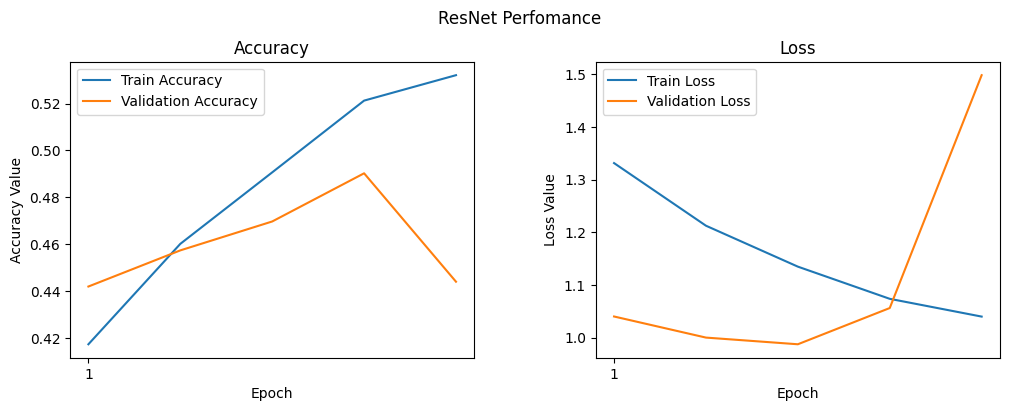

In [35]:
# Plotting performance
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(resnet_history.history['accuracy']) + 1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, resnet_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, resnet_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, resnet_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, resnet_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [36]:
# Predictions and Confusion Matrix
predictions_resnet = resnet_model.predict(test_imgs_scaled)
predicted_labels_resnet = np.argmax(predictions_resnet, axis=1)
true_labels_resnet = np.argmax(test_labels_1hotenc, axis=1)
conf_mat_resnet = confusion_matrix(true_labels_resnet, predicted_labels_resnet)

19/19 [==============================] - 1s 30ms/step


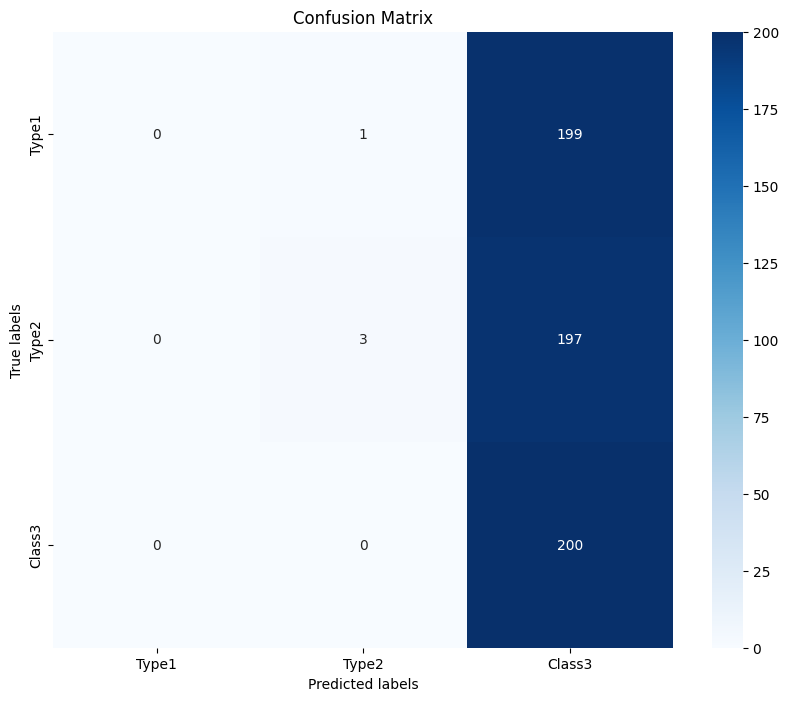

In [37]:
# Compute confusion matrix
conf_mat = confusion_matrix(true_labels_resnet, predicted_labels_resnet)
class_names = ['Type1', 'Type2', 'Type3'] 
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# DenseNet

In [ ]:
densenetNet = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet',
                                                input_shape=INPUT_SHAPE)
densenetNet.trainable = False

# Freeze the layers
for layer in densenetNet.layers:
    layer.trainable = False

base_densenet = densenetNet
base_out_densenet = base_densenet.output
pool_out_densenet = tf.keras.layers.GlobalAveragePooling2D()(base_out_densenet)
hidden1_densenet = tf.keras.layers.Dense(512, activation='relu')(pool_out_densenet)
batch_norm1_densenet = tf.keras.layers.BatchNormalization()(hidden1_densenet)
drop1_densenet = tf.keras.layers.Dropout(rate=0.3)(batch_norm1_densenet)
hidden2_densenet = tf.keras.layers.Dense(512, activation='relu')(drop1_densenet)
batch_norm2_densenet = tf.keras.layers.BatchNormalization()(hidden2_densenet)
drop2_densenet = tf.keras.layers.Dropout(rate=0.3)(batch_norm2_densenet)
out_densenet = tf.keras.layers.Dense(3, activation='softmax')(drop2_densenet)

densenet_model = tf.keras.Model(inputs=base_densenet.input, outputs=out_densenet)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

densenet_model.summary()

In [29]:
EPOCHS = 50
# Training
densenet_history = densenet_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      validation_data=(val_imgs_scaled, val_labels_1hotenc),
                                      verbose=1)

Epoch 1/50


2024-04-17 18:18:03.377646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-17 18:18:03.590732: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 18:18:05.228813: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcf6b706620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 18:18:05.228847: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-17 18:18:05.233300: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 18:18:05.359035: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 [==============================] - 27s 110ms/step - loss: 1.2028 - accuracy: 0.5390 - val_loss: 0.7846 - val_accuracy: 0.6984
Epoch 2/50
139/139 [==============================] - 14s 99ms/step - loss: 0.8547 - accuracy: 0.6657 - val_loss: 0.6144 - val_accuracy: 0.7652
Epoch 3/50
139/139 [==============================] - 13s 90ms/step - loss: 0.7317 - accuracy: 0.7049 - val_loss: 0.5733 - val_accuracy: 0.7642
Epoch 4/50
139/139 [==============================] - 12s 84ms/step - loss: 0.6591 - accuracy: 0.7357 - val_loss: 0.5538 - val_accuracy: 0.7834
Epoch 5/50
139/139 [==============================] - 12s 87ms/step - loss: 0.6044 - accuracy: 0.7539 - val_loss: 0.5201 - val_accuracy: 0.7925
Epoch 6/50
139/139 [==============================] - 12s 83ms/step - loss: 0.5473 - accuracy: 0.7832 - val_loss: 0.5247 - val_accuracy: 0.7844
Epoch 7/50
139/139 [==============================] - 13s 93ms/step - loss: 0.4978 - accuracy: 0.7988 - val_loss: 0.5118 - val_accuracy: 0.7986
Ep

In [49]:
# Evaluation
densenet_model_accuracy = densenet_history.history['accuracy'][np.argmin(densenet_history.history['loss'])]
densenet_model_score = densenet_model.evaluate(test_imgs_scaled, test_labels_1hotenc)

# Printing summary
densenet_Summary = PrettyTable(["DenseNet"," "])
densenet_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(densenet_model_accuracy*100)])
densenet_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(densenet_model_score[1]*100)])
densenet_Summary.add_row(["Test Loss in %", "{:.2f}".format(densenet_model_score[0]*100)])
print(densenet_Summary)

19/19 [==============================] - 1s 40ms/step - loss: 1.9249 - accuracy: 0.6500
+---------------------+--------+
|       DenseNet      |        |
+---------------------+--------+
| Model Accuracy in % | 98.40  |
|  Test Accuracy in % | 65.00  |
|    Test Loss in %   | 192.49 |
+---------------------+--------+


19/19 [==============================] - 1s 37ms/step


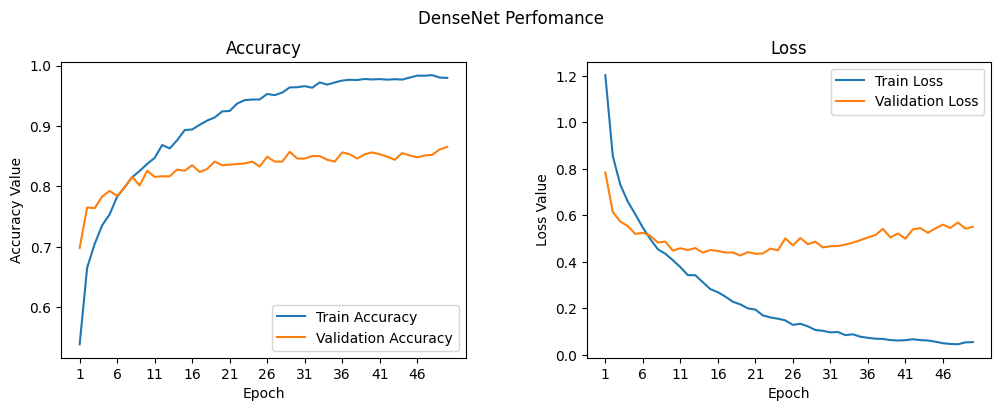

In [50]:
# Plotting performance
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('DenseNet Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(densenet_history.history['accuracy']) + 1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, densenet_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, densenet_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, densenet_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, densenet_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Predictions and Confusion Matrix
predictions_densenet = densenet_model.predict(test_imgs_scaled)
predicted_labels_densenet = np.argmax(predictions_densenet, axis=1)
true_labels_densenet = np.argmax(test_labels_1hotenc, axis=1)
conf_mat_densenet = confusion_matrix(true_labels_densenet, predicted_labels_densenet)


In [51]:
densenet_model.save('densenet_cvx_2.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


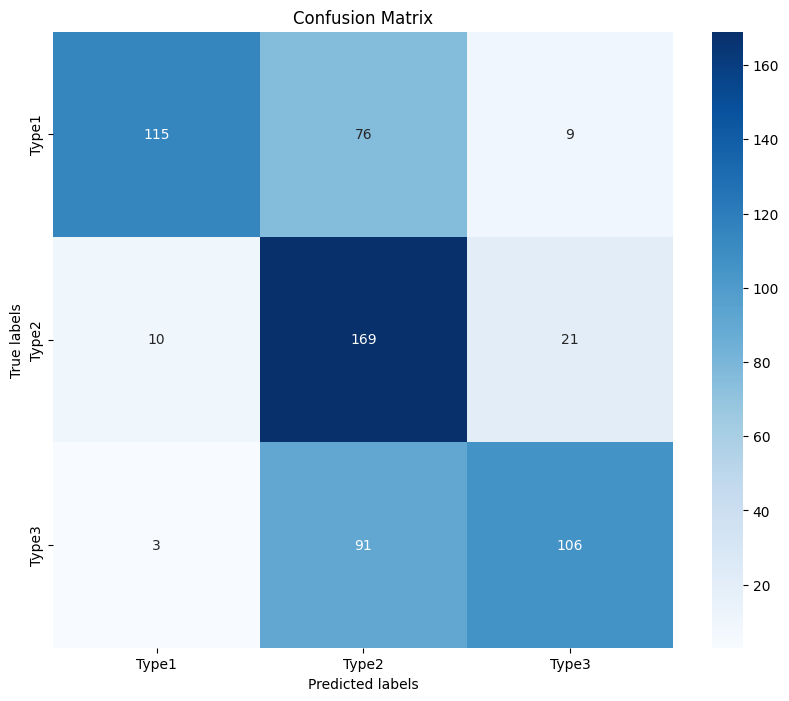

In [52]:
# Compute confusion matrix
conf_mat = confusion_matrix(true_labels_densenet, predicted_labels_densenet)
class_names = ['Type1', 'Type2', 'Type3'] 
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

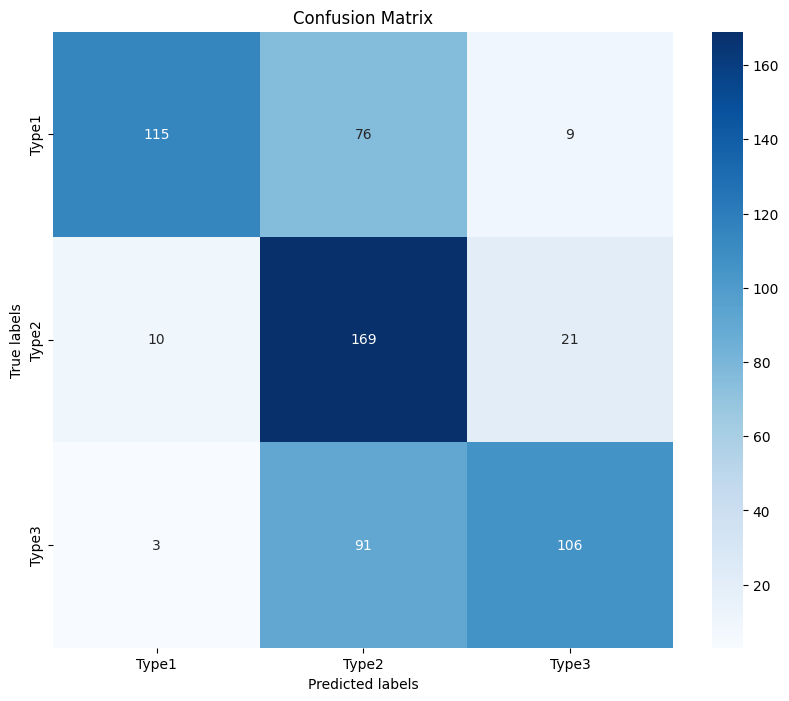

In [53]:
# Compute confusion matrix

class_names = ['Type1', 'Type2', 'Type3'] 
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:
class_report = classification_report(true_labels_densenet, predicted_labels_densenet, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

       Type1       0.90      0.57      0.70       200
       Type2       0.50      0.84      0.63       200
       Type3       0.78      0.53      0.63       200

    accuracy                           0.65       600
   macro avg       0.73      0.65      0.65       600
weighted avg       0.73      0.65      0.65       600



In [56]:
test_files_df['True_Labels'] = true_labels_densenet
test_files_df['Predicted_Labels'] = predicted_labels_densenet


In [59]:
test_files_df.to_excel('predictions2.xlsx')